In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

# Class imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

# Set random seed
np.random.seed(42)

# Plotting settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [4]:
print("Loading processed data...")

# Load training and test data
X_train = pd.read_csv('/Users/kashishpatel/Desktop/customer-churn-project/data/processed/X_train.csv')
X_test = pd.read_csv('/Users/kashishpatel/Desktop/customer-churn-project/data/processed/X_test.csv')
y_train = pd.read_csv('/Users/kashishpatel/Desktop/customer-churn-project/data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('/Users/kashishpatel/Desktop/customer-churn-project/data/processed/y_test.csv').values.ravel()

# Load scaled versions
X_train_scaled = pd.read_csv('/Users/kashishpatel/Desktop/customer-churn-project/data/processed/X_train_scaled.csv')
X_test_scaled = pd.read_csv('/Users/kashishpatel/Desktop/customer-churn-project/data/processed/X_test_scaled.csv')

# Load scaler
with open('/Users/kashishpatel/Desktop/customer-churn-project/data/processed/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print("✅ Data loaded successfully!")
print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nChurn distribution in training:")
print(f"  No churn: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Churn: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

Loading processed data...
✅ Data loaded successfully!

Training set: (5634, 72)
Test set: (1409, 72)

Churn distribution in training:
  No churn: 4139 (73.5%)
  Churn: 1495 (26.5%)


In [6]:
print("Handling class imbalance with SMOTE...")
print("SMOTE = Synthetic Minority Over-sampling Technique")
print("It creates synthetic samples of the minority class (churned customers)\n")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training set: {X_train.shape}")
print(f"Balanced training set: {X_train_balanced.shape}")

print(f"\nClass distribution BEFORE SMOTE:")
print(f"  No churn: {(y_train == 0).sum()}")
print(f"  Churn: {(y_train == 1).sum()}")

print(f"\nClass distribution AFTER SMOTE:")
print(f"  No churn: {(y_train_balanced == 0).sum()}")
print(f"  Churn: {(y_train_balanced == 1).sum()}")

print("\n✅ Classes are now balanced!")

Handling class imbalance with SMOTE...
SMOTE = Synthetic Minority Over-sampling Technique
It creates synthetic samples of the minority class (churned customers)

Original training set: (5634, 72)
Balanced training set: (8278, 72)

Class distribution BEFORE SMOTE:
  No churn: 4139
  Churn: 1495

Class distribution AFTER SMOTE:
  No churn: 4139
  Churn: 4139

✅ Classes are now balanced!


In [8]:
import os

print("Setting up MLflow experiment tracking...")

# Set MLflow tracking directory
mlflow_dir = '/Users/kashishpatel/Desktop/customer-churn-project/mlruns'
os.makedirs(mlflow_dir, exist_ok=True)
mlflow.set_tracking_uri(f"file://{mlflow_dir}")

# Create or set experiment
experiment_name = "customer-churn-prediction"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id

mlflow.set_experiment(experiment_name)

print(f"✅ MLflow initialized!")
print(f"Experiment: {experiment_name}")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"\n💡 You can view experiments later with: mlflow ui")

Setting up MLflow experiment tracking...
✅ MLflow initialized!
Experiment: customer-churn-prediction
Tracking URI: file:///Users/kashishpatel/Desktop/customer-churn-project/mlruns

💡 You can view experiments later with: mlflow ui


In [10]:
print("="*80)
print("MODEL 1: LOGISTIC REGRESSION (Baseline)")
print("="*80)

with mlflow.start_run(run_name="Logistic_Regression_Baseline"):
    # Train model
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train_balanced, y_train_balanced)
    
    # Predictions
    y_pred_lr = lr_model.predict(X_test)
    y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_lr)
    precision = precision_score(y_test, y_pred_lr)
    recall = recall_score(y_test, y_pred_lr)
    f1 = f1_score(y_test, y_pred_lr)
    roc_auc = roc_auc_score(y_test, y_pred_proba_lr)
    
    # Log parameters and metrics to MLflow
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("balanced_data", "SMOTE")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)
    
    # Log model
    mlflow.sklearn.log_model(lr_model, "model")
    
    # Print results
    print(f"\n📊 RESULTS:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred_lr, target_names=['No Churn', 'Churn']))

# Store for comparison
results = {
    'Logistic Regression': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred_lr,
        'y_pred_proba': y_pred_proba_lr
    }
}

print("\n✅ Logistic Regression complete!")

MODEL 1: LOGISTIC REGRESSION (Baseline)


2026/01/19 21:11:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 RESULTS:
Accuracy:  0.7601
Precision: 0.5361
Recall:    0.7139
F1 Score:  0.6124
ROC AUC:   0.8188

📋 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.88      0.78      0.83      1035
       Churn       0.54      0.71      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409


✅ Logistic Regression complete!


In [12]:
print("="*80)
print("MODEL 2: RANDOM FOREST")
print("="*80)

with mlflow.start_run(run_name="Random_Forest"):
    # Train model
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_balanced, y_train_balanced)
    
    # Predictions
    y_pred_rf = rf_model.predict(X_test)
    y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf)
    recall = recall_score(y_test, y_pred_rf)
    f1 = f1_score(y_test, y_pred_rf)
    roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
    
    # Log to MLflow
    mlflow.log_param("model_type", "Random Forest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("balanced_data", "SMOTE")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)
    
    mlflow.sklearn.log_model(rf_model, "model")
    
    # Print results
    print(f"\n📊 RESULTS:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred_rf, target_names=['No Churn', 'Churn']))

# Store results
results['Random Forest'] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'y_pred': y_pred_rf,
    'y_pred_proba': y_pred_proba_rf
}

print("\n✅ Random Forest complete!")

MODEL 2: RANDOM FOREST


2026/01/19 21:12:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 RESULTS:
Accuracy:  0.7679
Precision: 0.5485
Recall:    0.7112
F1 Score:  0.6193
ROC AUC:   0.8355

📋 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.88      0.79      0.83      1035
       Churn       0.55      0.71      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409


✅ Random Forest complete!


In [14]:
print("="*80)
print("MODEL 3: XGBOOST (Gradient Boosting)")
print("="*80)

with mlflow.start_run(run_name="XGBoost"):
    # Train model
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_model.fit(X_train_balanced, y_train_balanced)
    
    # Predictions
    y_pred_xgb = xgb_model.predict(X_test)
    y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_xgb)
    precision = precision_score(y_test, y_pred_xgb)
    recall = recall_score(y_test, y_pred_xgb)
    f1 = f1_score(y_test, y_pred_xgb)
    roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)
    
    # Log to MLflow
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("balanced_data", "SMOTE")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)
    
    mlflow.xgboost.log_model(xgb_model, "model")
    
    # Print results
    print(f"\n📊 RESULTS:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred_xgb, target_names=['No Churn', 'Churn']))

# Store results
results['XGBoost'] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'y_pred': y_pred_xgb,
    'y_pred_proba': y_pred_proba_xgb
}

print("\n✅ XGBoost complete!")

2026/01/19 21:12:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MODEL 3: XGBOOST (Gradient Boosting)

📊 RESULTS:
Accuracy:  0.7764
Precision: 0.5774
Recall:    0.5882
F1 Score:  0.5828
ROC AUC:   0.8302

📋 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.84      0.85      1035
       Churn       0.58      0.59      0.58       374

    accuracy                           0.78      1409
   macro avg       0.71      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409


✅ XGBoost complete!


In [16]:
print("="*80)
print("MODEL 4: LIGHTGBM (Fast Gradient Boosting)")
print("="*80)

with mlflow.start_run(run_name="LightGBM"):
    # Train model
    lgbm_model = LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    )
    lgbm_model.fit(X_train_balanced, y_train_balanced)
    
    # Predictions
    y_pred_lgbm = lgbm_model.predict(X_test)
    y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_lgbm)
    precision = precision_score(y_test, y_pred_lgbm)
    recall = recall_score(y_test, y_pred_lgbm)
    f1 = f1_score(y_test, y_pred_lgbm)
    roc_auc = roc_auc_score(y_test, y_pred_proba_lgbm)
    
    # Log to MLflow
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("balanced_data", "SMOTE")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)
    
    mlflow.lightgbm.log_model(lgbm_model, "model")
    
    # Print results
    print(f"\n📊 RESULTS:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred_lgbm, target_names=['No Churn', 'Churn']))

# Store results
results['LightGBM'] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'y_pred': y_pred_lgbm,
    'y_pred_proba': y_pred_proba_lgbm
}

print("\n✅ LightGBM complete!")

2026/01/19 21:12:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MODEL 4: LIGHTGBM (Fast Gradient Boosting)

📊 RESULTS:
Accuracy:  0.7814
Precision: 0.5882
Recall:    0.5882
F1 Score:  0.5882
ROC AUC:   0.8282

📋 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.85      0.85      1035
       Churn       0.59      0.59      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409


✅ LightGBM complete!


# print("="*80)
print("MODEL COMPARISON")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1 Score': [results[m]['f1'] for m in results.keys()],
    'ROC AUC': [results[m]['roc_auc'] for m in results.keys()]
})

print("\n📊 MODEL PERFORMANCE SUMMARY:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False, color='steelblue')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.savefig('/Users/kashishpatel/Desktop/customer-churn-project/models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Find best model
best_model_name = comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Model']
print(f"\n🏆 BEST MODEL (by ROC AUC): {best_model_name}")
print(f"ROC AUC Score: {comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'ROC AUC']:.4f}")

Plotting ROC curves for all models...


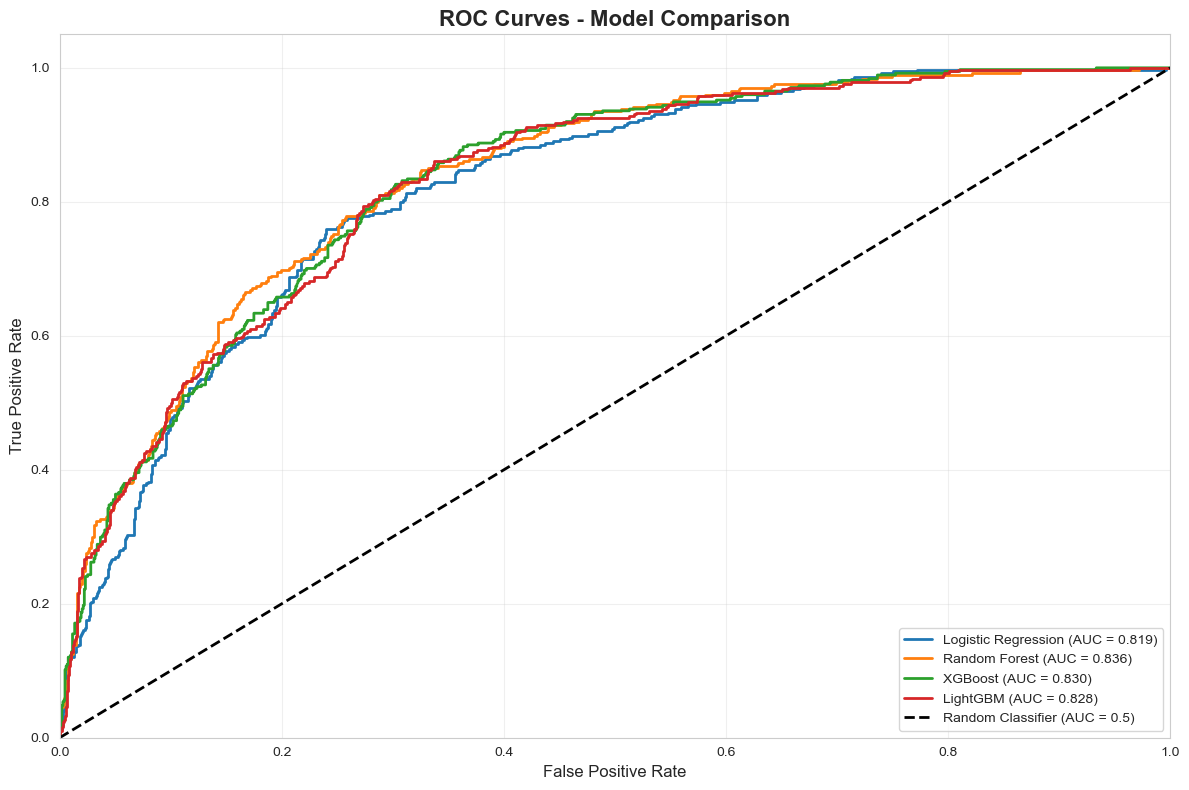

✅ ROC curves plotted!


In [22]:
print("Plotting ROC curves for all models...")

plt.figure(figsize=(12, 8))

for model_name in results.keys():
    y_pred_proba = results[model_name]['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = results[model_name]['roc_auc']
    
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('/Users/kashishpatel/Desktop/customer-churn-project/models/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ROC curves plotted!")

Plotting confusion matrices...


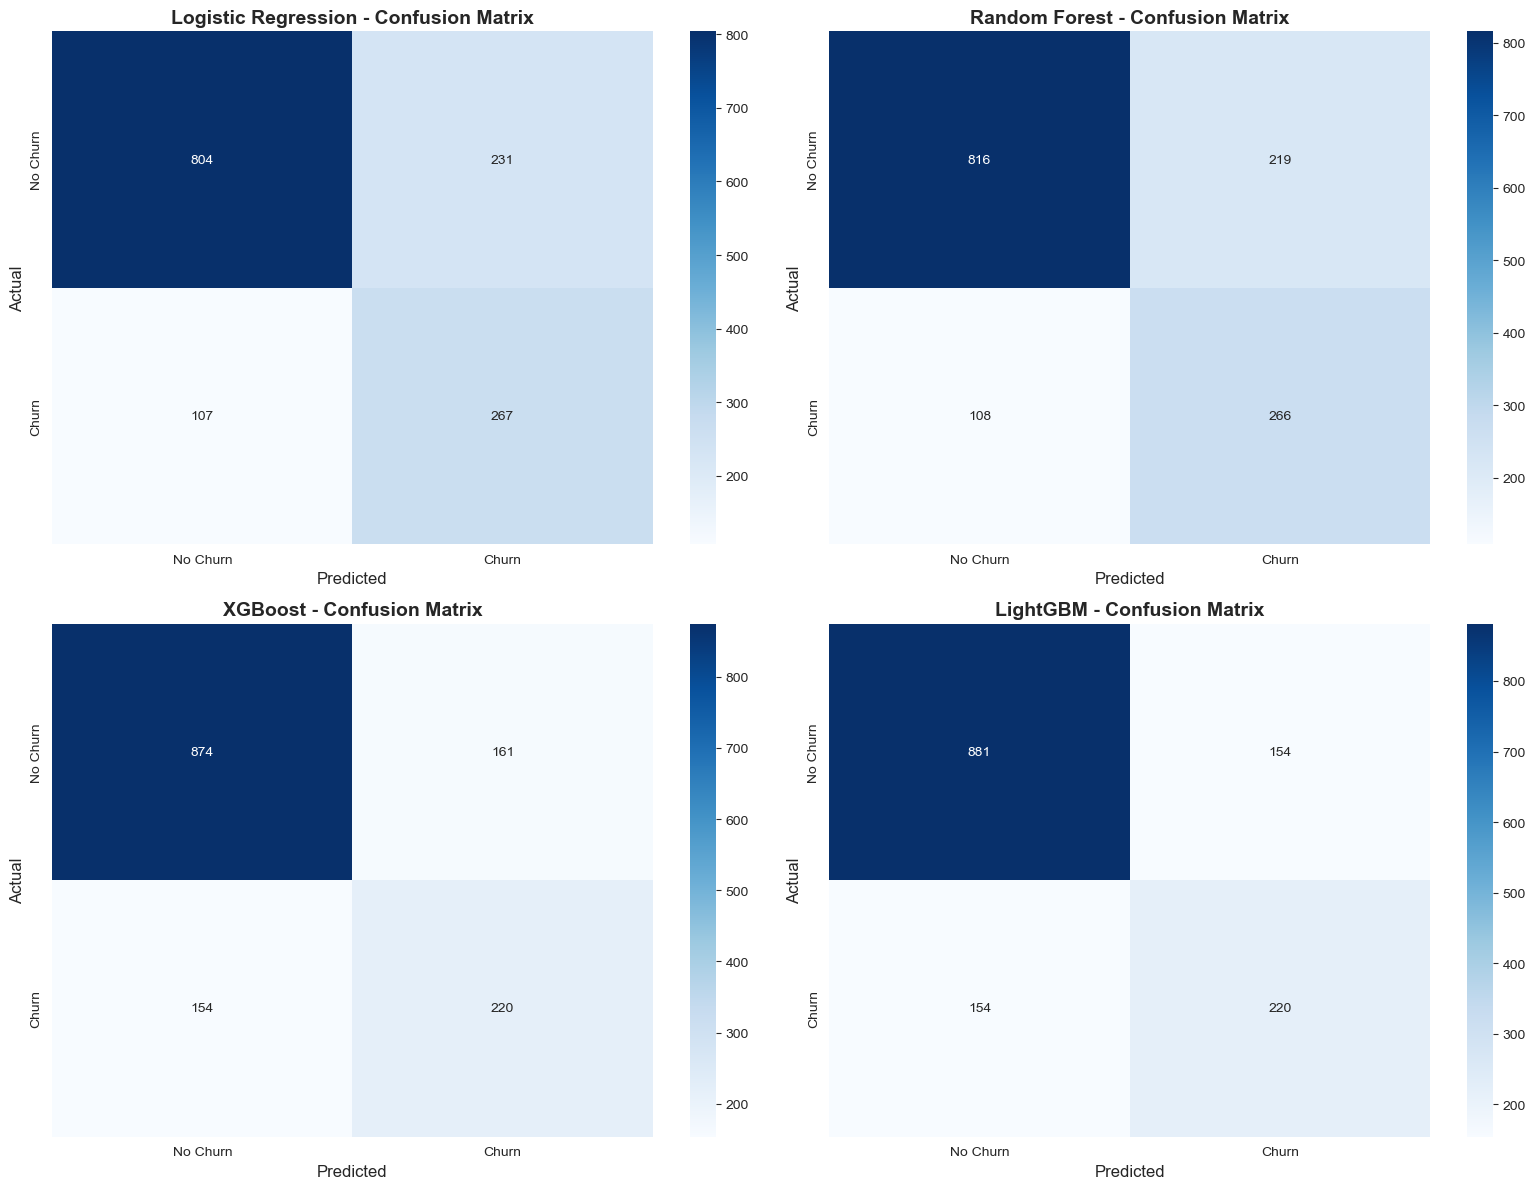

✅ Confusion matrices plotted!


In [24]:
print("Plotting confusion matrices...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, model_name in enumerate(results.keys()):
    ax = axes[idx // 2, idx % 2]
    y_pred = results[model_name]['y_pred']
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    ax.set_title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
plt.savefig('/Users/kashishpatel/Desktop/customer-churn-project/models/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrices plotted!")

In [26]:
import os

print("Saving the best model...")

# Create models directory
os.makedirs('/Users/kashishpatel/Desktop/customer-churn-project/models', exist_ok=True)

# Determine best model (by ROC AUC)
best_model_name = max(results.keys(), key=lambda k: results[k]['roc_auc'])
print(f"Best model: {best_model_name}")

# Get the actual model object
if best_model_name == 'Logistic Regression':
    best_model = lr_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'XGBoost':
    best_model = xgb_model
else:  # LightGBM
    best_model = lgbm_model

# Save with pickle
with open('/Users/kashishpatel/Desktop/customer-churn-project/models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'metrics': results[best_model_name],
    'features': X_train.columns.tolist()
}

with open('/Users/kashishpatel/Desktop/customer-churn-project/models/model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)

print(f"✅ Best model saved: {best_model_name}")
print(f"Location: /Users/kashishpatel/Desktop/customer-churn-project/models/best_model.pkl")

Saving the best model...
Best model: Random Forest
✅ Best model saved: Random Forest
Location: /Users/kashishpatel/Desktop/customer-churn-project/models/best_model.pkl


In [28]:
print("="*80)
print("PHASE 2 COMPLETE: MODEL TRAINING & EVALUATION")
print("="*80)

print("\n📊 WHAT WE ACCOMPLISHED:")
print("  ✅ Handled class imbalance with SMOTE")
print("  ✅ Trained 4 different models:")
print("     • Logistic Regression (baseline)")
print("     • Random Forest")
print("     • XGBoost")
print("     • LightGBM")
print("  ✅ Tracked all experiments with MLflow")
print("  ✅ Compared model performance")
print("  ✅ Saved the best model")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"  • ROC AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"  • F1 Score: {results[best_model_name]['f1']:.4f}")
print(f"  • Precision: {results[best_model_name]['precision']:.4f}")
print(f"  • Recall: {results[best_model_name]['recall']:.4f}")

print("\n📁 SAVED ARTIFACTS:")
print("  • Best model: models/best_model.pkl")
print("  • Model metadata: models/model_metadata.pkl")
print("  • ROC curves: models/roc_curves.png")
print("  • Confusion matrices: models/confusion_matrices.png")
print("  • Model comparison: models/model_comparison.png")

print("\n🎯 NEXT PHASE:")
print("  PHASE 3: Explainability & Counterfactual Analysis")
print("  • SHAP values for feature importance")
print("  • Global and local interpretability")
print("  • DICE-ML for counterfactual explanations")
print("  • Generate actionable recommendations")

print("\n💡 TO VIEW MLFLOW EXPERIMENTS:")
print("  1. Open terminal in your project folder")
print("  2. Run: mlflow ui")
print("  3. Open browser: http://localhost:5000")

print("\n" + "="*80)

PHASE 2 COMPLETE: MODEL TRAINING & EVALUATION

📊 WHAT WE ACCOMPLISHED:
  ✅ Handled class imbalance with SMOTE
  ✅ Trained 4 different models:
     • Logistic Regression (baseline)
     • Random Forest
     • XGBoost
     • LightGBM
  ✅ Tracked all experiments with MLflow
  ✅ Compared model performance
  ✅ Saved the best model

🏆 BEST MODEL: Random Forest
  • ROC AUC: 0.8355
  • F1 Score: 0.6193
  • Precision: 0.5485
  • Recall: 0.7112

📁 SAVED ARTIFACTS:
  • Best model: models/best_model.pkl
  • Model metadata: models/model_metadata.pkl
  • ROC curves: models/roc_curves.png
  • Confusion matrices: models/confusion_matrices.png
  • Model comparison: models/model_comparison.png

🎯 NEXT PHASE:
  PHASE 3: Explainability & Counterfactual Analysis
  • SHAP values for feature importance
  • Global and local interpretability
  • DICE-ML for counterfactual explanations
  • Generate actionable recommendations

💡 TO VIEW MLFLOW EXPERIMENTS:
  1. Open terminal in your project folder
  2. Run: mlfl